In [1]:
import os
import librosa.display
import numpy as np
from data_preprocess import extract_features, extract_stft_features
import matplotlib.pyplot as plt
import random

In [20]:
def load_segmented_files(directory, target_sr=48000):
    wav_files = []
    leak_wav_files = []
    for dir in os.listdir(directory):
        if not os.path.isdir(os.path.join(directory, dir)):
            continue
        for file in os.listdir(os.path.join(directory, dir)):
            if not file.endswith(".wav"):
                continue
            file_path = os.path.join(directory, dir, file)
            y, sr = librosa.load(file_path, sr=None)
            print(f"檔案 {file_path} 的取樣率為 {sr}")
            if sr != target_sr:
                    y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            filename = f'{dir}_{file}'
            if 'no-leak' in dir:
                wav_files.append((y, sr, filename))
            if 'leak' in dir:
                leak_wav_files.append((y, sr, filename))
    print(f"共有 {len(wav_files) + len(leak_wav_files)} 個 wav 檔案，其中 {len(leak_wav_files)} 個有泄漏，{len(wav_files)} 個沒有泄漏")
    return wav_files, leak_wav_files

def shuffle_data(wav_files, leak_wav_files, n_files=None):
    wav_files = random.sample(wav_files, n_files if n_files else len(wav_files))
    leak_wav_files = random.sample(leak_wav_files, n_files if n_files else len(leak_wav_files))

    return wav_files, leak_wav_files


In [21]:
# 載入訓練資料
wav_files, leak_wav_files = load_segmented_files('validate_data/2024-10-29')
wav_files, leak_wav_files = shuffle_data(wav_files, leak_wav_files, n_files=0)

檔案 validate_data/2024-10-29\leak\2024-10-28T112422.wav 的取樣率為 48000
檔案 validate_data/2024-10-29\leak\2024-10-29T101030.wav 的取樣率為 48000
檔案 validate_data/2024-10-29\leak\2024-10-29T101048.wav 的取樣率為 48000
檔案 validate_data/2024-10-29\leak\2024-10-29T101052.wav 的取樣率為 48000
檔案 validate_data/2024-10-29\no-leak\2024-10-29T100953.wav 的取樣率為 48000
檔案 validate_data/2024-10-29\no-leak\2024-10-29T101717.wav 的取樣率為 48000
檔案 validate_data/2024-10-29\no-leak\2024-10-29T101845.wav 的取樣率為 48000
共有 10 個 wav 檔案，其中 7 個有泄漏，3 個沒有泄漏


In [22]:

normal_wavs = np.array([y for y, sr, filename in wav_files])
leak_wavs = np.array([y for y, sr, filename in leak_wav_files])



In [14]:
def plot_mel_spectrogram(mel_spectrogram, sr, hop_length):
    """
    繪製 Mel 頻譜圖。

    Args:
        mel_spectrogram (np.ndarray): Mel 頻譜圖，形狀為 (時間, n_mels)。
        sr (int): 取樣率。
        hop_length (int): hop length。
    """
    plt.figure(figsize=(10, 4))
    # 繪製 Mel 頻譜圖
    librosa.display.specshow(mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()
    
    
def plot_stft(S_db, sr, hop_length=512):
    """
    繪製音訊的短時傅立葉變換（STFT）。

    Args:
        audio (np.ndarray): 音訊資料。
        sr (int): 取樣率。
        hop_length (int): hop length。
    """


    # 繪製 STFT 頻譜圖
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='log', y_axis='time', cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.title('STFT Magnitude')
    plt.tight_layout()
    plt.show()

(192, 128)


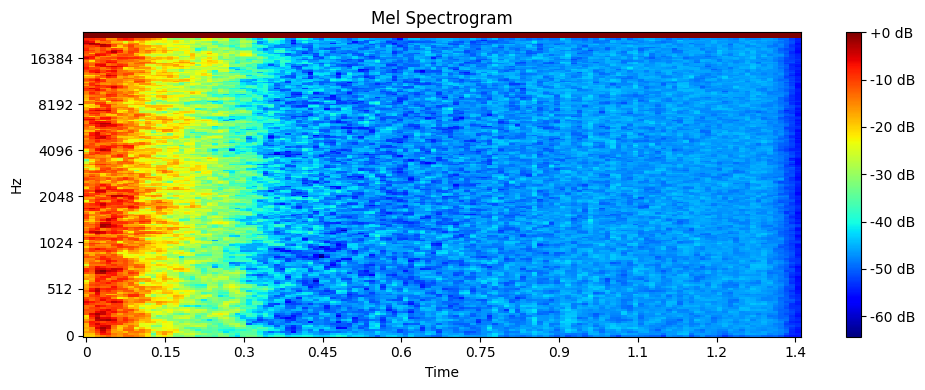

(192, 128)


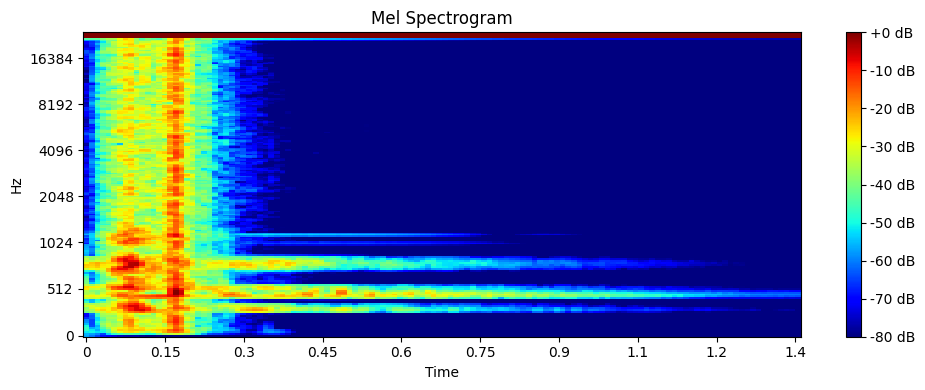

(192, 128)


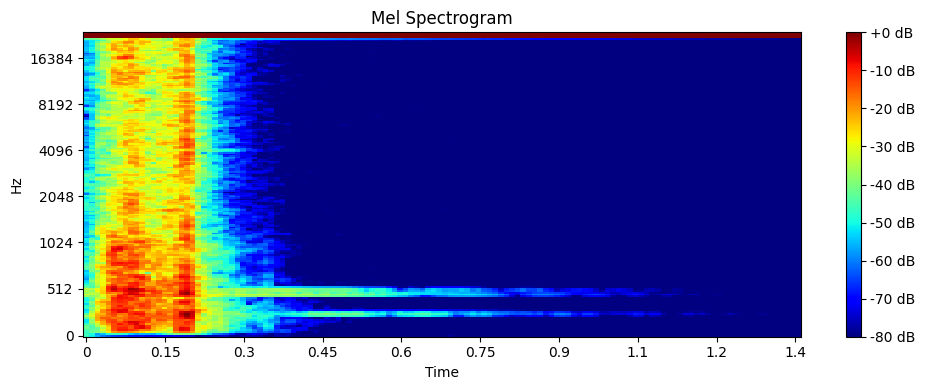

In [23]:
# 繪製 Mel 頻譜圖
hop_length = 512
for i in normal_wavs[:5]:
    mel_spectrogram = extract_features(i, sr=48000, n_mels=128, n_fft=2048, hop_length=hop_length)
    print(mel_spectrogram.shape)
    plot_mel_spectrogram(mel_spectrogram, sr=48000, hop_length=hop_length)


(88, 128)


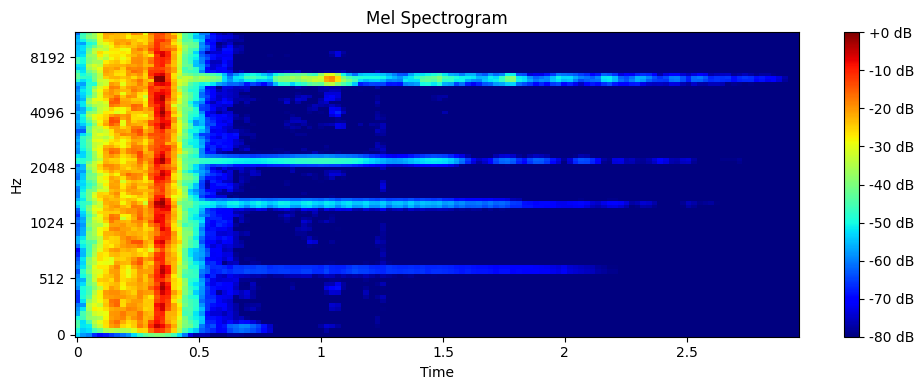

(88, 128)


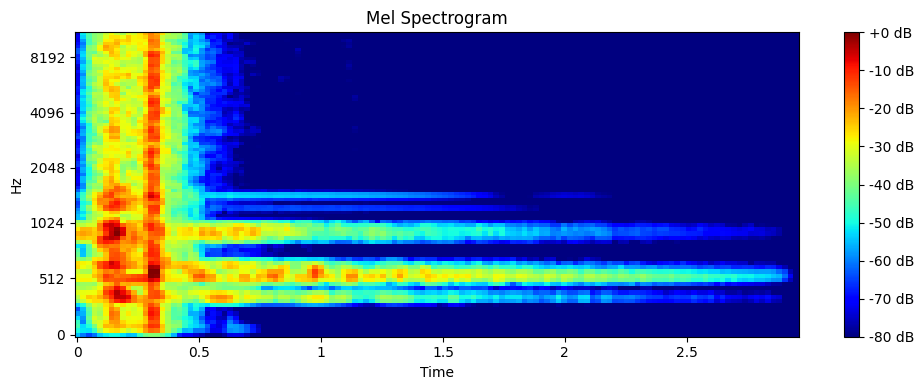

(88, 128)


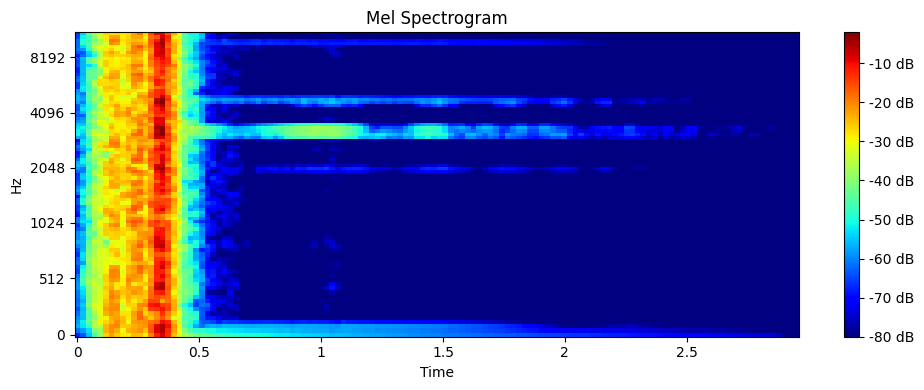

(88, 128)


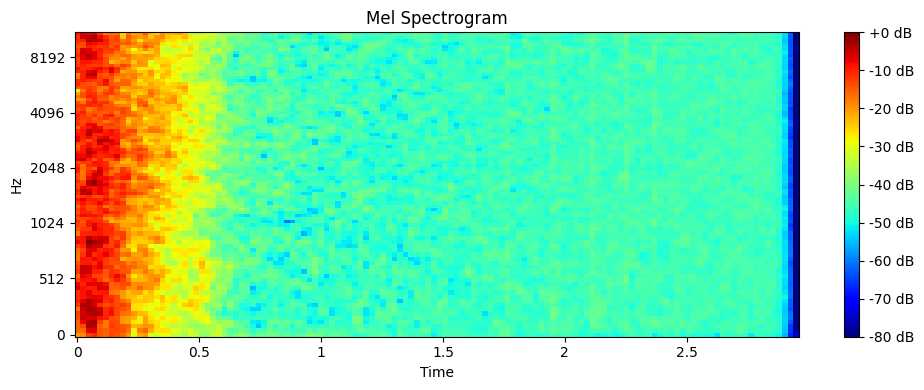

(88, 128)


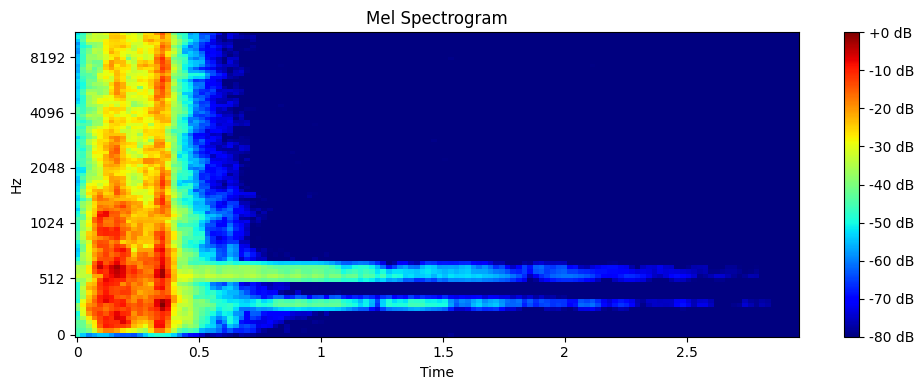

In [7]:
    
for i in leak_wavs[:5]:
    mel_spectrogram = extract_features(i, sr=32000, n_mels=128, n_fft=2048, hop_length=512)
    print(mel_spectrogram.shape)
    plot_mel_spectrogram(mel_spectrogram, sr=32000, hop_length=512)

(192, 1025)


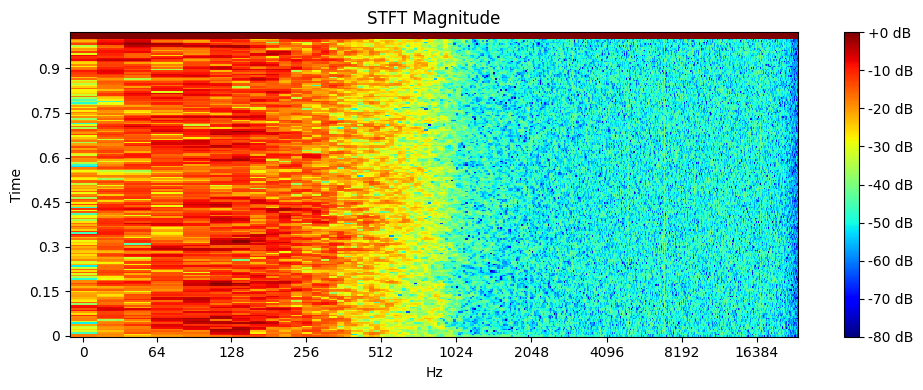

(192, 1025)


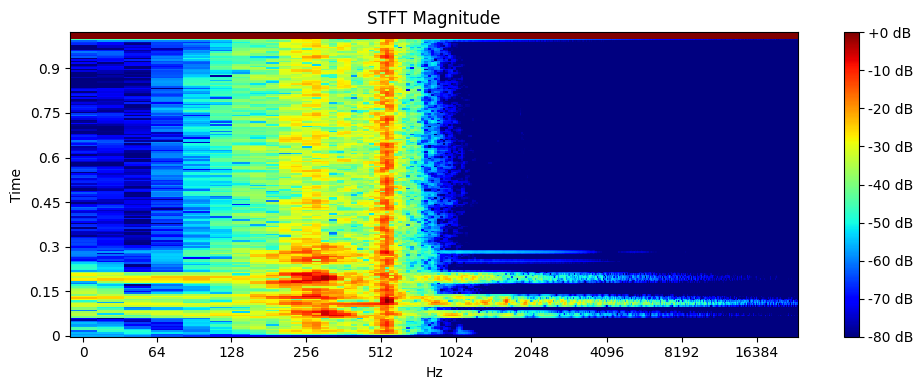

(192, 1025)


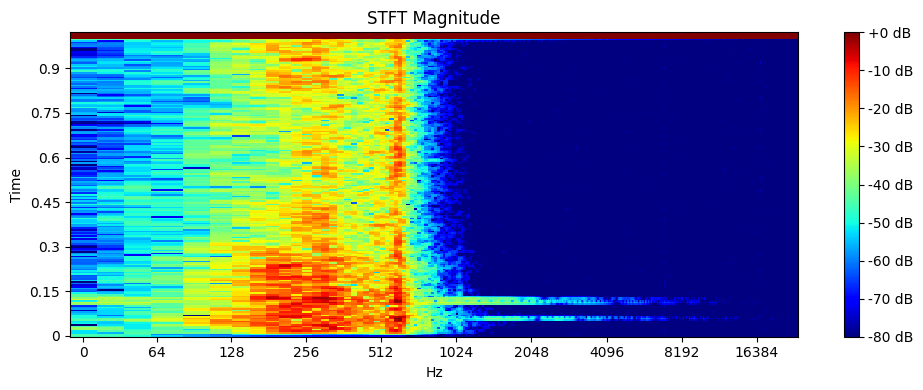

In [27]:
# 繪製 STFT 頻譜圖
hop_length = 256
for i in normal_wavs[:5]:
    S_db = extract_stft_features(i, sr=48000, n_fft=2048, hop_length=512)
    print(S_db.shape)
    plot_stft(S_db, sr=48000, hop_length=hop_length)

In [ ]:
for i in leak_wavs[:5]:
    S_db = extract_stft_features(i, sr=32000, n_fft=256, hop_length=256)
    print(S_db.shape)
    plot_stft(S_db, sr=32000, hop_length=512)